In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# Part 1 - Building up a basic predictive model

## Data cleaning and transformation

### Show the shape of the dataset

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("Manhattan12.csv", skiprows=4)
df.shape

(27395, 21)

### Rename incorrectly formatted column names (e.g. SALE\nPRICE)

In [3]:
df.columns = df.columns.str.replace("\n", "").str.replace(" ", "_")
df.rename(columns={"SALEPRICE": "SALE_PRICE", "APARTMENTNUMBER": "APARTMENT_NUMBER"}, inplace=True)

### Create list of categorical variables and another for the numerical variables
### For each numerical column, remove the ',' the '$' for the sale price, and then convert them to numeric.
### Convert the 'SALE DATE' to datetime.

In [4]:
df.columns = df.columns.str.strip().str.replace("\n", "")

def format_and_convert_column_to_numeric(col, dtype):
    df[col] = df[col].str.replace(",","").str.replace("$","").astype(dtype)
    
format_and_convert_column_to_numeric('SALE_PRICE', np.int64)
# format_and_convert_column_to_numeric('GROSS_SQUARE_FEET', np.float64)
# format_and_convert_column_to_numeric('LAND_SQUARE_FEET', np.float64)
# format_and_convert_column_to_numeric('RESIDENTIAL_UNITS', np.int64)
# format_and_convert_column_to_numeric('TOTAL_UNITS', np.int64)

# Convert To datetime
df['SALE_DATE'] =pd.to_datetime(df['SALE_DATE'], dayfirst=True)

df['YEAR_BUILT'] = df['YEAR_BUILT'].astype(np.int64)

/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_27428/168732407.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace(",","").str.replace("$","").astype(dtype)


### Create list of categorical variables and another for the numerical variables

In [5]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
print("Categorical columns: ", categorical)
print("Numerical columns: ", numerical)

Categorical columns:  ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'RESIDENTIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'BUILDING_CLASS_AT_TIME_OF_SALE']
Numerical columns:  ['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'COMMERCIAL_UNITS', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE']


### For each categorical variable, remove the spaces, and then replace the empty string '' by NaN.

In [6]:
df[categorical] = df[categorical].applymap(lambda x: x.replace(r" +", ""))
df[categorical] = df[categorical].applymap(lambda x: " ".join(x.split()))

### Replace the zeros in Prices, Land squares, etc. by NaN

In [7]:
df[categorical] = df[categorical].replace("", np.nan)
df[numerical] = df[numerical].replace(0, np.nan)

### Show a summary of all missing values as well as the summary statistics (Percentage)

In [8]:
df.isna().sum() / df.shape[0] * 100

BOROUGH                             0.000000
NEIGHBORHOOD                        0.062055
BUILDING_CLASS_CATEGORY            12.608140
TAX_CLASS_AT_PRESENT                0.521993
BLOCK                               0.000000
LOT                                 0.000000
EASE-MENT                         100.000000
BUILDING_CLASS_AT_PRESENT           0.521993
ADDRESS                             0.000000
APARTMENT_NUMBER                   53.184888
ZIP_CODE                            0.003650
RESIDENTIAL_UNITS                   0.000000
COMMERCIAL_UNITS                   87.468516
TOTAL_UNITS                         0.000000
LAND_SQUARE_FEET                    0.000000
GROSS_SQUARE_FEET                   0.000000
YEAR_BUILT                         23.511590
TAX_CLASS_AT_TIME_OF_SALE           0.000000
BUILDING_CLASS_AT_TIME_OF_SALE      0.000000
SALE_PRICE                         27.716737
SALE_DATE                           0.000000
dtype: float64

### Drop the columns 'BOROUGH', 'EASE-MENT', 'APARTMENT NUMBER'

In [9]:
df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
df.columns

Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

### Drop duplicates if any
### Drop rows with NaN values

In [10]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.isna().sum()

NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

### Identify and remove outliers if any

In [11]:
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
z_scores = np.abs(stats.zscore(df[numerical]))

In [12]:
new_df = df[(z_scores<3).all(axis=1)]

### Show the shape of the resulting dataframe.

In [13]:
new_df.shape

(1454, 18)

In [14]:
new_df.describe()

,BLOCK,LOT,ZIP_CODE,COMMERCIAL_UNITS,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1.454000e+03
mean,1028.976616,54.223521,10019.631362,2.314305,1961.826685,3.425034,7.191310e+06
std,447.776768,128.593279,10.423728,2.138585,46.598890,0.947823,1.913755e+07
min,11.000000,1.000000,10001.000000,1.000000,1877.000000,1.000000,1.000000e+00
25%,862.000000,31.000000,10017.000000,2.000000,1913.000000,2.000000,5.911575e+04
50%,1009.000000,37.000000,10019.000000,2.000000,1987.500000,4.000000,2.027735e+05
75%,1009.000000,37.000000,10019.000000,2.000000,2007.000000,4.000000,5.898750e+06
max,2246.000000,1033.000000,10075.000000,24.000000,2011.000000,4.000000,1.892500e+08


### Consider the log of the prices and normalise the data.

In [15]:

new_df['SALE_PRICE'] = np.log(df['SALE_PRICE'])


/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_27428/1768186329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['SALE_PRICE'] = np.log(df['SALE_PRICE'])


In [16]:
numerical.remove("SALE_PRICE")
new_df[numerical] = (new_df[numerical] - new_df[numerical].min()) / (new_df[numerical].max() - new_df[numerical].min())
numerical.append("SALE_PRICE")

/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_27428/1282489056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[numerical] = (new_df[numerical] - new_df[numerical].min()) / (new_df[numerical].max() - new_df[numerical].min())


In [17]:
new_df.describe()

,BLOCK,LOT,ZIP_CODE,COMMERCIAL_UNITS,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,0.455471,0.051573,0.251775,0.057144,0.633035,0.808345,13.221939
std,0.200348,0.124606,0.140861,0.092982,0.347753,0.315941,2.888313
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380761,0.029070,0.216216,0.043478,0.268657,0.333333,10.987253
50%,0.446532,0.034884,0.243243,0.043478,0.824627,1.000000,12.219092
75%,0.446532,0.034884,0.243243,0.043478,0.970149,1.000000,15.590251
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.058579


## Data Exploration

### Visualise the prices across neighborhood

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, 'ALPHABET CITY'),
  Text(1, 0, 'CHELSEA'),
  Text(2, 0, 'CHINATOWN'),
  Text(3, 0, 'CIVIC CENTER'),
  Text(4, 0, 'CLINTON'),
  Text(5, 0, 'EAST VILLAGE'),
  Text(6, 0, 'FASHION'),
  Text(7, 0, 'FINANCIAL'),
  Text(8, 0, 'FLATIRON'),
  Text(9, 0, 'GRAMERCY'),
  Text(10, 0, 'GREENWICH VILLAGE-CENTRAL'),
  Text(11, 0, 'GREENWICH VILLAGE-WEST'),
  Text(12, 0, 'HARLEM-CENTRAL'),
  Text(13, 0, 'HARLEM-EAST'),
  Text(14, 0, 'HARLEM-UPPER'),
  Text(15, 0, 'HARLEM-WEST'),
  Text(16, 0, 'INWOOD'),
  Text(17, 0, 'JAVITS CENTER'),
  Text(18, 0, 'KIPS BAY'),
  Text(19, 0, 'LITTLE ITALY'),
  Text(20, 0, 'LOWER EAST SIDE'),
  Text(21, 0, 'MANHATTAN VALLEY'),
  Text(22, 0, 'MIDTOWN CBD'),
  Text(23, 0, 'MIDTOWN EAST'),
  Text(24, 0, 'MIDTOWN WEST'),
  Text(25, 0, 'MORNINGSIDE HEIGHTS'),
  Text(26, 0, 'MURRAY HILL'),
 

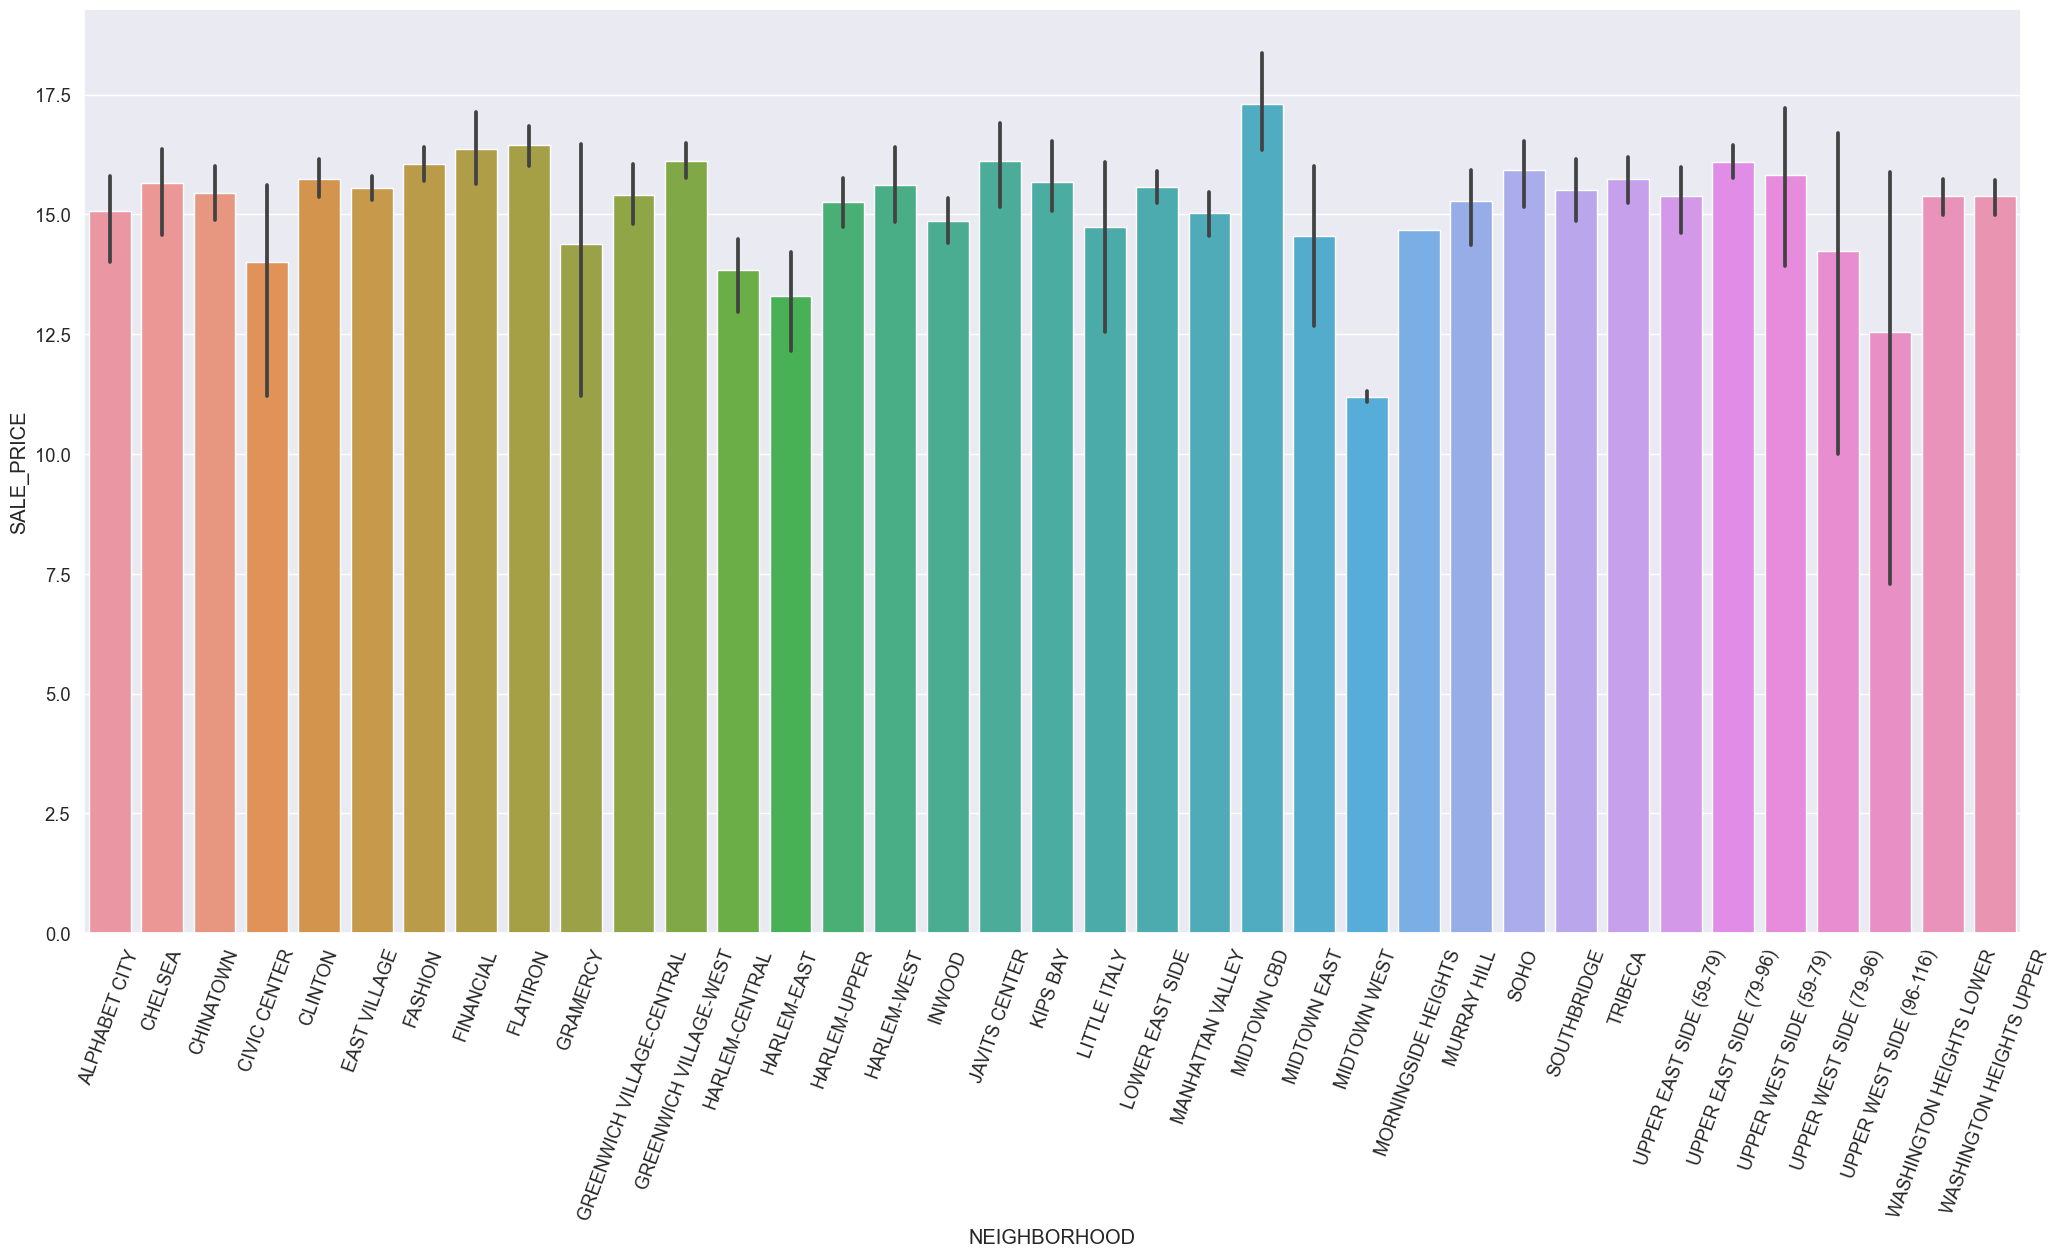

In [18]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
fig = sns.barplot(data=new_df ,y='SALE_PRICE', x='NEIGHBORHOOD')
plt.xticks(rotation=70)

### Correlation Matrix

<AxesSubplot: >

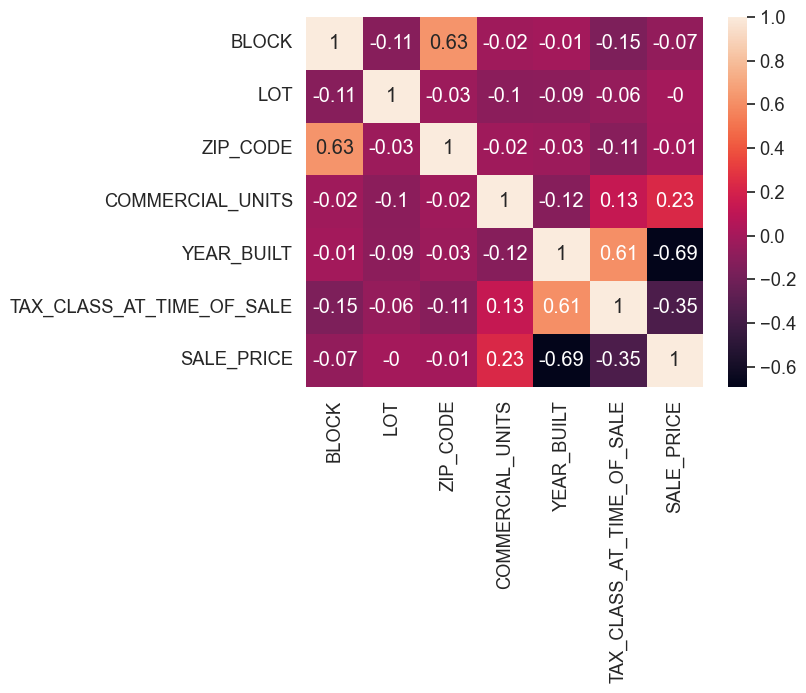

In [19]:
sns.heatmap(new_df[numerical].corr().round(2), annot=True)

### Scatter Matrix Plot

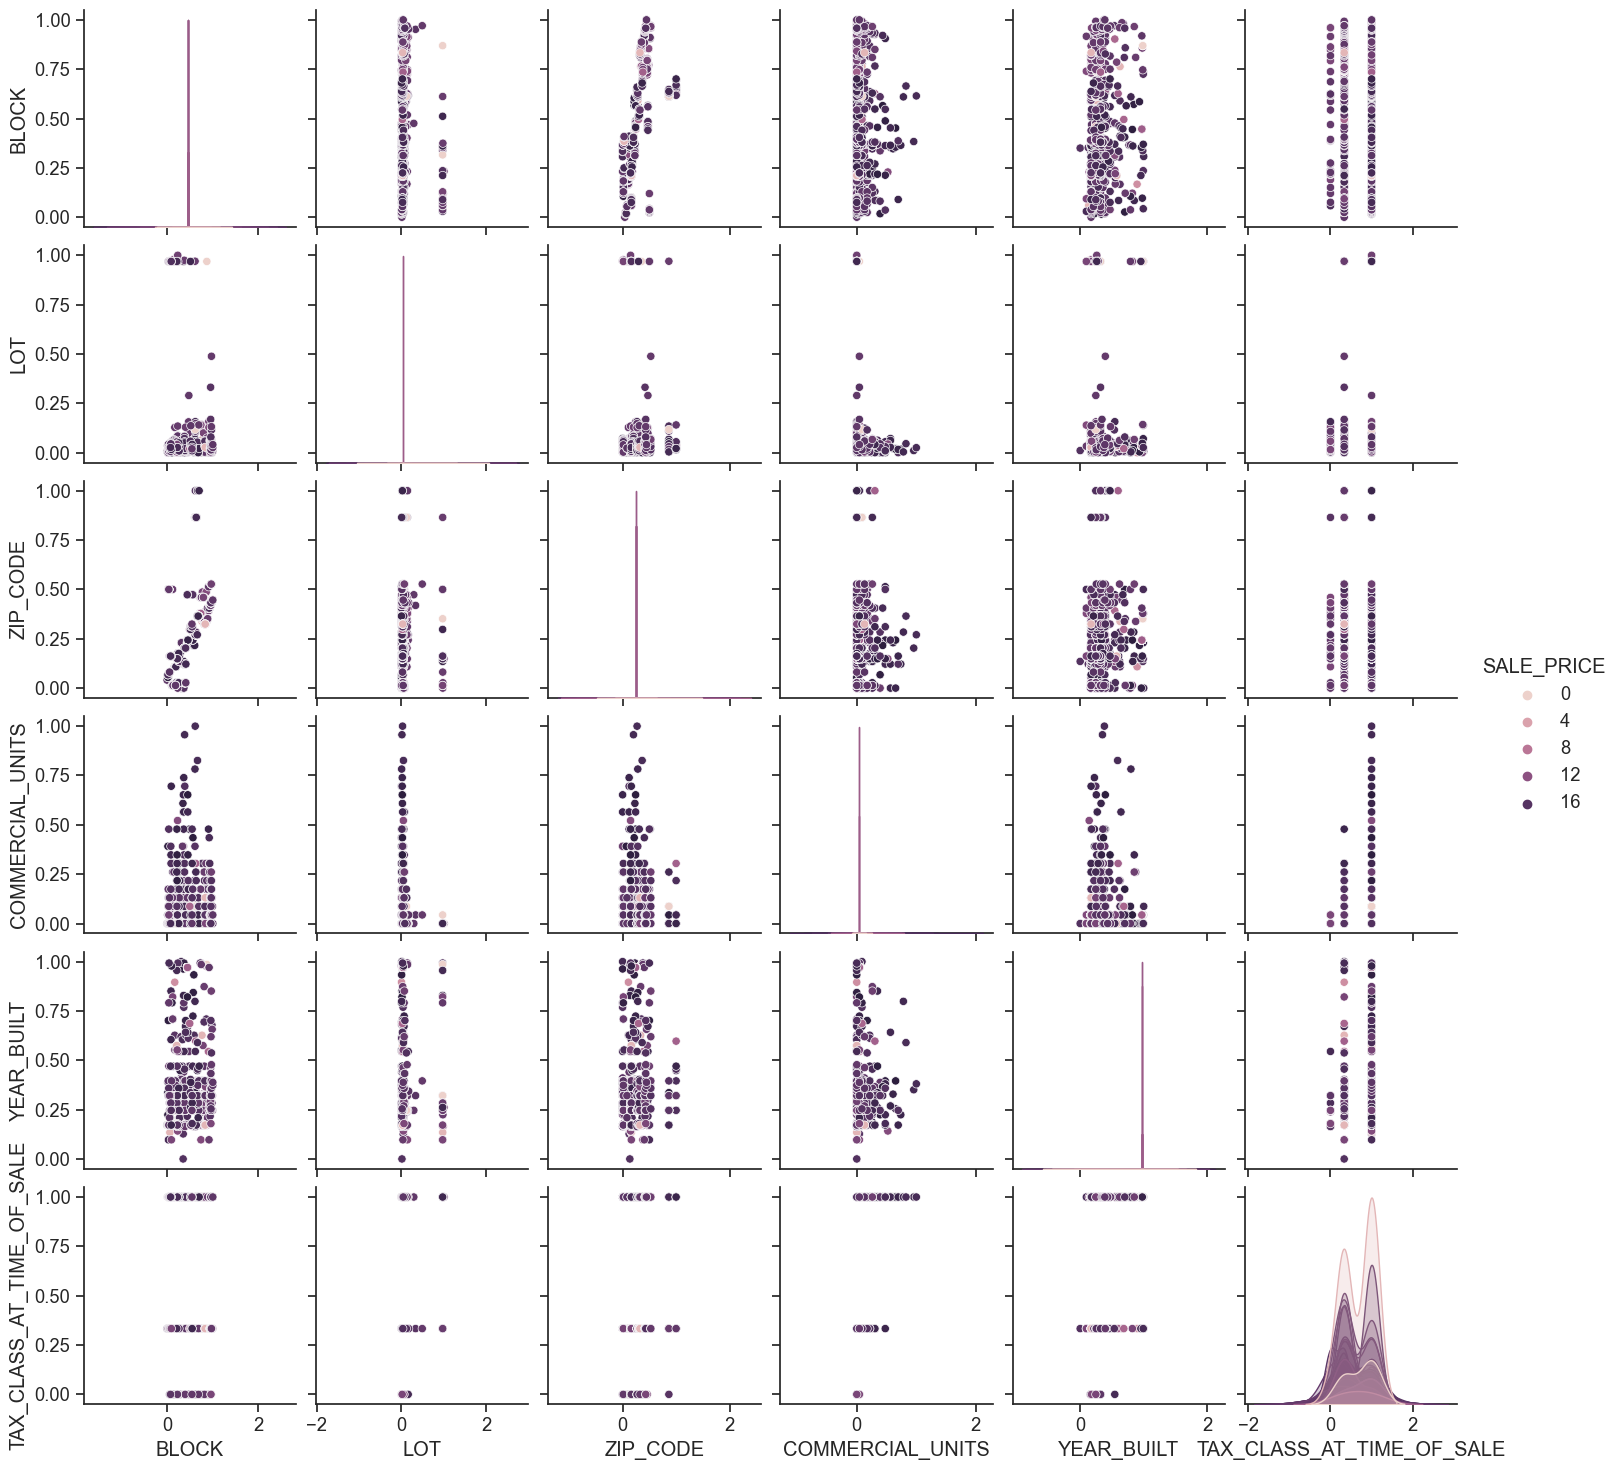

In [20]:
sns.set_theme(style='ticks', font_scale=1.2, palette='mako')
sns.pairplot(data=new_df, hue='SALE_PRICE')

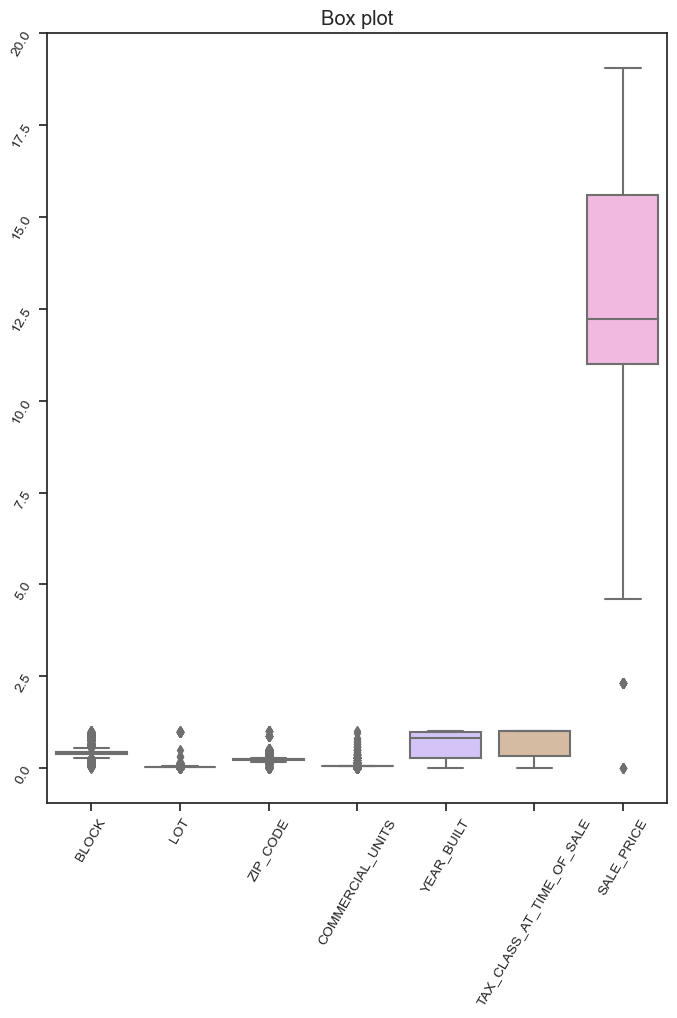

In [21]:
plt.figure(figsize=(8, 10))
fig = sns.boxplot(data=new_df, palette='pastel').set(title='Box plot')
sns.set( font_scale=0.8)
plt.tick_params(axis='both', which='major', labelsize=10, rotation=60)

In [22]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 24 to 27386
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   NEIGHBORHOOD                    1454 non-null   object        
 1   BUILDING_CLASS_CATEGORY         1454 non-null   object        
 2   TAX_CLASS_AT_PRESENT            1454 non-null   object        
 3   BLOCK                           1454 non-null   float64       
 4   LOT                             1454 non-null   float64       
 5   BUILDING_CLASS_AT_PRESENT       1454 non-null   object        
 6   ADDRESS                         1454 non-null   object        
 7   ZIP_CODE                        1454 non-null   float64       
 8   RESIDENTIAL_UNITS               1454 non-null   object        
 9   COMMERCIAL_UNITS                1454 non-null   float64       
 10  TOTAL_UNITS                     1454 non-null   object        
 11  LA

## Model building

### Select the predictors that would have impact in predicting house prices. 

In [23]:
new_df = new_df.iloc[:, [0, 1, 8, 10, 11, 12, 15, 3, 4, 7, 9, 13, 14, 16]]
new_df.iloc[:, :10]

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,RESIDENTIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,BLOCK,LOT,ZIP_CODE
24,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,7,8,"2,093","5,852",C7,0.167338,0.000000,0.108108
26,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,25,27,"3,574","18,212",C7,0.172707,0.031008,0.108108
30,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,36,39,"4,452","17,664",C7,0.173154,0.050388,0.108108
31,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,10,10,"2,404","6,975",C4,0.174049,0.053295,0.108108
32,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,9,9,"2,404","6,875",C4,0.174049,0.054264,0.108108
...,...,...,...,...,...,...,...,...,...,...
27378,WASHINGTON HEIGHTS UPPER,27 FACTORIES,0,1,"17,275","34,570",F9,1.000000,0.026163,0.445946
27380,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,0,1,"17,925","5,226",G9,0.957942,0.073643,0.432432
27381,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,0,1,"17,925","5,226",G9,0.957942,0.073643,0.432432
27382,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,0,1,"15,000","2,465",G9,0.957942,0.079457,0.432432


In [24]:
X = new_df.iloc[:, :-1]
y = new_df.iloc[:, -1]

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1, 2, 3, 4, 5, 6, 7, 8])], remainder='passthrough')
X = ct.fit_transform(X.values)

### Split the data into a training and test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=69420)

### Train Model

In [26]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

### Predict the test dataset

In [27]:
y_pred = regressor.predict(X_test)

### Model evaluation

In [28]:
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error - {mae}')
print(f'Mean Squared Error - {mse}')
print(f'Root Mean Squared Error - {rmse}')

Mean Absolute Error - 0.8726037046172843
Mean Squared Error - 2.852806180566584
Root Mean Squared Error - 1.6890252160836985


### Comparing the y_true and y_pred values side-by-side

In [29]:
predictions = pd.DataFrame(np.concatenate((y_test.reshape(-1, 1), y_pred.reshape(-1, 1)), axis=1), columns=['Y_TRUE', 'Y_PRED'])
predictions

,Y_TRUE,Y_PRED
0,16.663323,15.775591
1,11.281372,11.029727
2,10.614106,11.029727
3,11.420975,11.029727
4,13.244581,14.382639
...,...,...
286,10.835652,11.029727
287,15.006042,16.766090
288,15.454750,15.211812
289,15.226498,15.718107


### Cross Validation

In [30]:
results = cross_validate(LinearRegression(), X_test, y_test, cv=5, scoring=('r2', 'neg_root_mean_squared_error'))
print("Cross Validation results")
results

Cross Validation results


{'fit_time': array([0.00516391, 0.00518823, 0.00423288, 0.00426602, 0.00377107]),
 'score_time': array([0.00056815, 0.00048685, 0.00043607, 0.00043106, 0.00040603]),
 'test_r2': array([0.76570794, 0.53671862, 0.63121523, 0.74574439, 0.6446669 ]),
 'test_neg_root_mean_squared_error': array([-1.40772027, -1.9289687 , -1.60316253, -1.48070949, -1.7460612 ])}

### Histogram of the residuals

<AxesSubplot: ylabel='Count'>

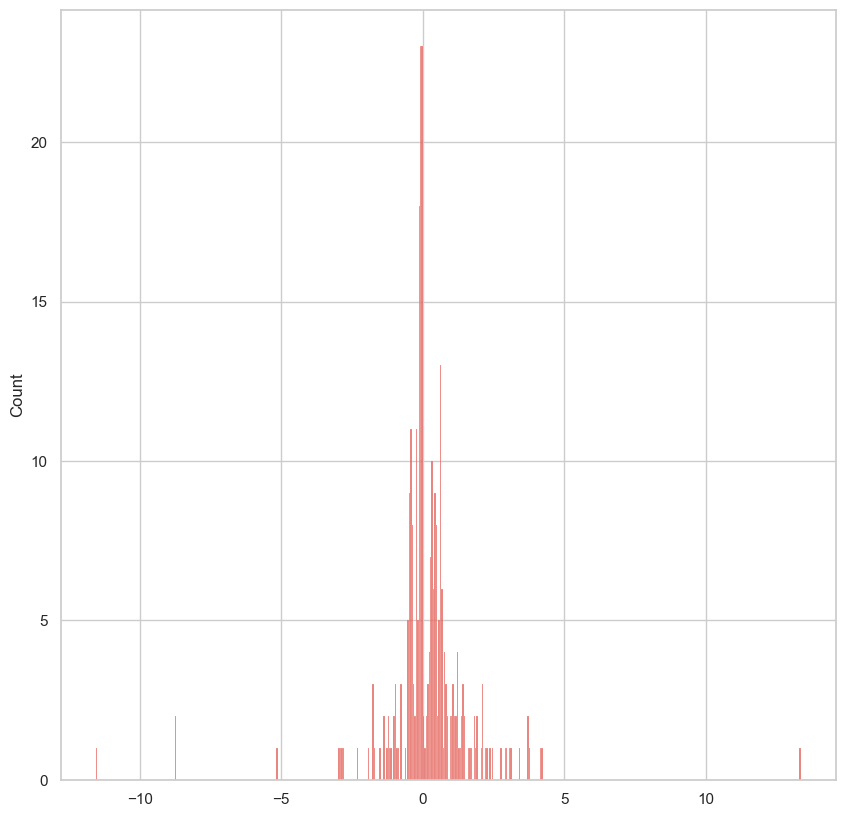

In [31]:
plt.figure(figsize=(10, 10))
sns.set_theme(style='whitegrid', font_scale=1, palette='Spectral')
sns.histplot(y_test - y_pred, bins=500)